In [19]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
#pytorch gpu 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [21]:
import torch
torch.__version__

'1.12.0'

# Download census-income dataset

In [22]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [23]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [24]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [25]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train


In [65]:
# type of each column
print(train.dtypes)

39                 int64
 State-gov         int32
 77516             int64
 Bachelors         int32
 13                int64
 Never-married     int32
 Adm-clerical      int32
 Not-in-family     int32
 White             int32
 Male              int32
 2174              int64
 0                 int64
 40                int64
 United-States     int32
 <=50K            object
Set                int32
dtype: object


In [64]:
print(train.nunique() )

39                   73
 State-gov            9
 77516            21647
 Bachelors           16
 13                  16
 Never-married        7
 Adm-clerical        15
 Not-in-family        6
 White                5
 Male                 2
 2174               119
 0                   92
 40                  94
 United-States       42
 <=50K                2
Set                   3
dtype: int64


In [63]:
print(train.isnull().sum() )

39                0
 State-gov        0
 77516            0
 Bachelors        0
 13               0
 Never-married    0
 Adm-clerical     0
 Not-in-family    0
 White            0
 Male             0
 2174             0
 0                0
 40               0
 United-States    0
 <=50K            0
Set               0
dtype: int64


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [26]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


In [27]:
# check that pipeline accepts strings
train.loc[train[target]==0, target] = "wealthy"
train.loc[train[target]==1, target] = "not_wealthy"

# Define categorical features for categorical embeddings

In [28]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


In [62]:
print(features)
print(cat_idxs)
print(cat_dims)

['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States']
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]


# Grouped features

You can now specify groups of feature which will share a common attention.

This may be very usefull for features comming from a same preprocessing technique like PCA for example.

In [29]:
len(features)

14

In [30]:
grouped_features = [[0, 1, 2], [8, 9, 10]]

# Network parameters

In [71]:
tabnet_params = {"cat_idxs":cat_idxs,
                 "cat_dims":cat_dims,
                 "cat_emb_dim":2,
                 "optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax', # "sparsemax" , Entmax는 Sparsemax보다 더 큰 값을 더욱 강조하는 특징이 있으며, Entmax는 Sparsemax의 일반화된 형태
                 "grouped_features" : grouped_features
                }

clf = TabNetClassifier(**tabnet_params
                      )

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [72]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [73]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [74]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

In [75]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        augmentations=aug, #aug, None
    )
    save_history.append(clf.history["valid_auc"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.59109 | train_auc: 0.82017 | valid_auc: 0.81892 |  0:00:01s
epoch 1  | loss: 0.48598 | train_auc: 0.85513 | valid_auc: 0.86347 |  0:00:02s
epoch 2  | loss: 0.45112 | train_auc: 0.87827 | valid_auc: 0.88781 |  0:00:03s
epoch 3  | loss: 0.4329  | train_auc: 0.89093 | valid_auc: 0.89663 |  0:00:05s
epoch 4  | loss: 0.41688 | train_auc: 0.9015  | valid_auc: 0.90433 |  0:00:06s
epoch 5  | loss: 0.41548 | train_auc: 0.90872 | valid_auc: 0.90946 |  0:00:07s
epoch 6  | loss: 0.39804 | train_auc: 0.91444 | valid_auc: 0.91418 |  0:00:09s
epoch 7  | loss: 0.39228 | train_auc: 0.91799 | valid_auc: 0.91603 |  0:00:10s
epoch 8  | loss: 0.38326 | train_auc: 0.92125 | valid_auc: 0.9206  |  0:00:11s
epoch 9  | loss: 0.37806 | train_auc: 0.92297 | valid_auc: 0.9232  |  0:00:12s
epoch 10 | loss: 0.38059 | train_auc: 0.92457 | valid_auc: 0.92332 |  0:00:14s
epoch 11 | loss: 0.37052 | train_auc: 0.92761 | valid_auc: 0.92709 |  0:00:15s
epoch 12 | loss: 0.36784 | train_auc: 0.9275  | vali

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.59109 | train_auc: 0.82017 | valid_auc: 0.81892 |  0:00:01s
epoch 1  | loss: 0.48598 | train_auc: 0.85513 | valid_auc: 0.86347 |  0:00:02s
epoch 2  | loss: 0.45112 | train_auc: 0.87827 | valid_auc: 0.88781 |  0:00:03s
epoch 3  | loss: 0.4329  | train_auc: 0.89093 | valid_auc: 0.89663 |  0:00:05s
epoch 4  | loss: 0.41688 | train_auc: 0.9015  | valid_auc: 0.90433 |  0:00:06s
epoch 5  | loss: 0.41548 | train_auc: 0.90872 | valid_auc: 0.90946 |  0:00:07s
epoch 6  | loss: 0.39804 | train_auc: 0.91444 | valid_auc: 0.91418 |  0:00:09s
epoch 7  | loss: 0.39228 | train_auc: 0.91799 | valid_auc: 0.91603 |  0:00:10s
epoch 8  | loss: 0.38326 | train_auc: 0.92125 | valid_auc: 0.9206  |  0:00:11s
epoch 9  | loss: 0.37806 | train_auc: 0.92297 | valid_auc: 0.9232  |  0:00:12s
epoch 10 | loss: 0.38059 | train_auc: 0.92457 | valid_auc: 0.92332 |  0:00:14s
epoch 11 | loss: 0.37052 | train_auc: 0.92761 | valid_auc: 0.92709 |  0:00:15s
epoch 12 | loss: 0.36784 | train_auc: 0.9275  | vali

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


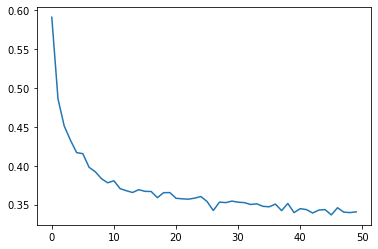

In [76]:
# plot losses
plt.plot(clf.history['loss'])

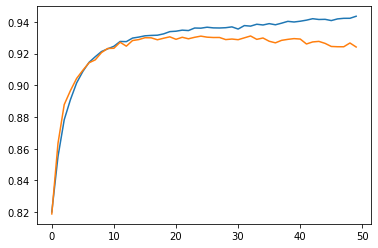

In [77]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

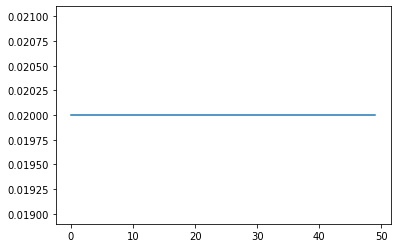

In [78]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [79]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9310603106414623
FINAL TEST SCORE FOR census-income : 0.9238293566635835


In [80]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [81]:
clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Save and load Model

In [82]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [83]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [84]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9238293566635835


In [85]:
assert(test_auc == loaded_test_auc)

In [86]:
loaded_clf.predict(X_test)

array(['not_wealthy', 'not_wealthy', 'wealthy', ..., 'not_wealthy',
       'wealthy', 'wealthy'], dtype='<U11')

# Global explainability : feat importance summing to 1

In [87]:
clf.feature_importances_

array([0.02947903, 0.02947903, 0.02947903, 0.06063349, 0.11925558,
       0.27498839, 0.05605762, 0.02174467, 0.05480086, 0.05480086,
       0.05480086, 0.05703344, 0.13717717, 0.02026998])

# Local explainability and masks

In [88]:
explain_matrix, masks = clf.explain(X_test)

<AxesSubplot:>

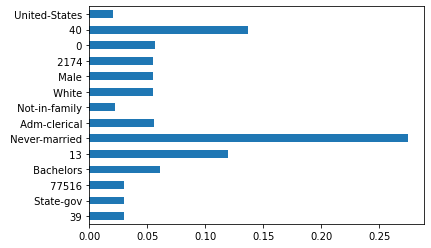

In [89]:
# global
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh')

C:\Users\USER\AppData\Local\Temp\ipykernel_182504\58949275.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels = features, rotation=45)


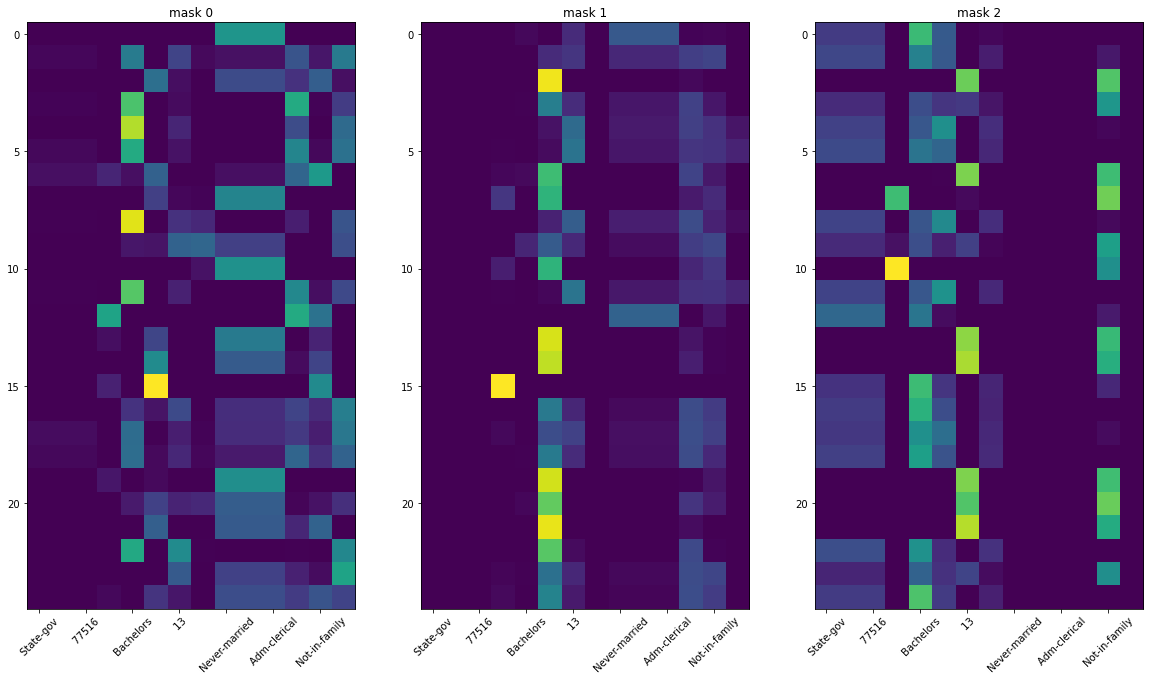

In [90]:
#local

fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = features, rotation=45)

# XGB

In [91]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-logloss:0.63523
[10]	validation_0-logloss:0.37927
[20]	validation_0-logloss:0.31122


c:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[30]	validation_0-logloss:0.28684
[40]	validation_0-logloss:0.27723
[50]	validation_0-logloss:0.27253
[60]	validation_0-logloss:0.26951
[70]	validation_0-logloss:0.26908
[80]	validation_0-logloss:0.26752
[90]	validation_0-logloss:0.26729
[100]	validation_0-logloss:0.26748
[110]	validation_0-logloss:0.26783
[120]	validation_0-logloss:0.26779
[130]	validation_0-logloss:0.26815
[140]	validation_0-logloss:0.26878
[142]	validation_0-logloss:0.26913


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              nthread=24, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.7, tree_method='exact',
              validate_parameters=1, ...)

In [92]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)

0.9336413537984218
0.9244487257452103


# ※ Pretraining_example

# Network parameters

In [107]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [108]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    grouped_features = grouped_features,
    verbose=5,
)

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [109]:
max_epochs = 100 if not os.getenv("CI", False) else 2 # 1000

In [110]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=5,
    batch_size=2048, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 6.17939 | val_0_unsup_loss_numpy: 3.1958200931549072|  0:00:00s
epoch 5  | loss: 1.07675 | val_0_unsup_loss_numpy: 1.1210800409317017|  0:00:05s
epoch 10 | loss: 1.04804 | val_0_unsup_loss_numpy: 1.0995800495147705|  0:00:09s
epoch 15 | loss: 0.98773 | val_0_unsup_loss_numpy: 1.0529500246047974|  0:00:13s
epoch 20 | loss: 0.89841 | val_0_unsup_loss_numpy: 1.0077500343322754|  0:00:17s
epoch 25 | loss: 0.88378 | val_0_unsup_loss_numpy: 0.9736599922180176|  0:00:22s
epoch 30 | loss: 0.8708  | val_0_unsup_loss_numpy: 0.963129997253418|  0:00:26s
epoch 35 | loss: 0.85952 | val_0_unsup_loss_numpy: 0.9382699728012085|  0:00:30s
epoch 40 | loss: 0.84538 | val_0_unsup_loss_numpy: 0.9183300137519836|  0:00:34s
epoch 45 | loss: 0.84505 | val_0_unsup_loss_numpy: 0.8873599767684937|  0:00:38s
epoch 50 | loss: 0.83213 | val_0_unsup_loss_numpy: 0.8682500123977661|  0:00:42s
epoch 55 | loss: 0.82941 | val_0_unsup_loss_numpy: 0.8375599980354309|  0:00:47s
epoch 60 | loss: 0.83087 | va

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [111]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

In [112]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)

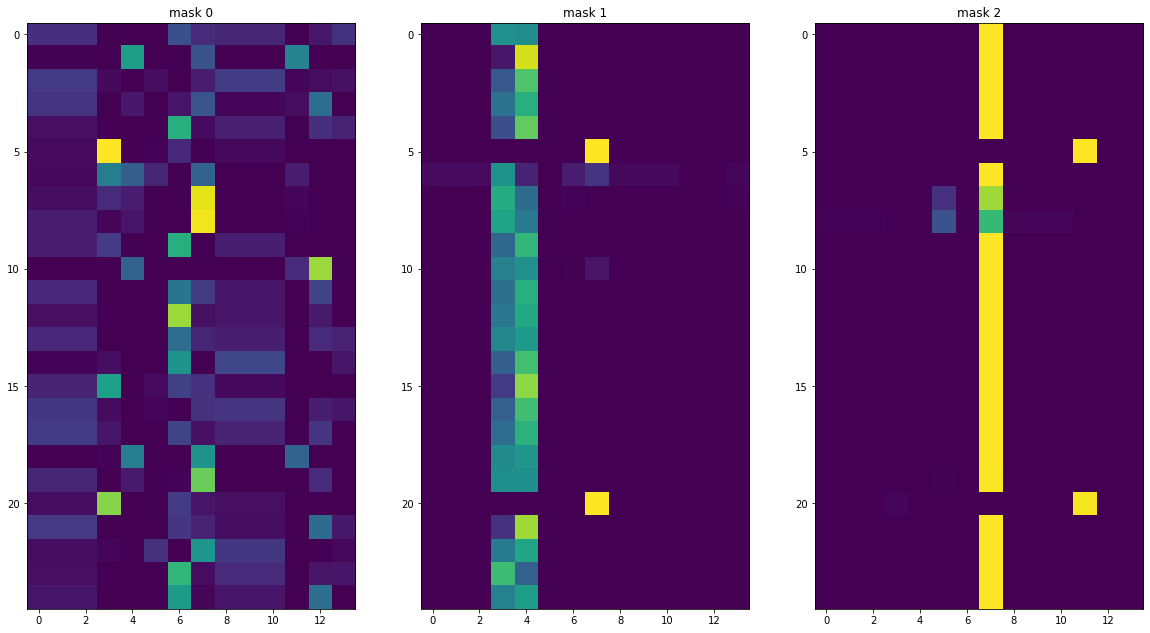

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:25])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [114]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip


c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:80: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [115]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

In [116]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain,
    
) 

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:116: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:116: UserWarning: Pretraining: cat_emb_dim changed from [] to [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
  warnings.warn(wrn_msg)
c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:116: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:116: UserWarning: Pretraining: grouped_features changed from [] to [[0, 1, 2], [8, 9, 10]]
  warnings.warn(wrn_msg)
c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\abstract_model.py:116: UserWarning: Pretraining: mask_type changed from sparsemax to entm

epoch 0  | loss: 1.23142 | train_auc: 0.55351 | valid_auc: 0.52902 |  0:00:01s
epoch 5  | loss: 0.42133 | train_auc: 0.89246 | valid_auc: 0.89701 |  0:00:08s
epoch 10 | loss: 0.38723 | train_auc: 0.90738 | valid_auc: 0.90867 |  0:00:15s
epoch 15 | loss: 0.37064 | train_auc: 0.91637 | valid_auc: 0.91555 |  0:00:22s
epoch 20 | loss: 0.36289 | train_auc: 0.92317 | valid_auc: 0.92061 |  0:00:29s
epoch 25 | loss: 0.35224 | train_auc: 0.92673 | valid_auc: 0.92351 |  0:00:36s
epoch 30 | loss: 0.34285 | train_auc: 0.93064 | valid_auc: 0.92684 |  0:00:43s
epoch 35 | loss: 0.33395 | train_auc: 0.93312 | valid_auc: 0.92766 |  0:00:50s
epoch 40 | loss: 0.32176 | train_auc: 0.93503 | valid_auc: 0.92794 |  0:00:57s
epoch 45 | loss: 0.32353 | train_auc: 0.93632 | valid_auc: 0.92934 |  0:01:04s
epoch 50 | loss: 0.32096 | train_auc: 0.93802 | valid_auc: 0.92943 |  0:01:11s
epoch 55 | loss: 0.32083 | train_auc: 0.93859 | valid_auc: 0.92954 |  0:01:17s
epoch 60 | loss: 0.31394 | train_auc: 0.93977 | vali

c:\Users\USER\Dropbox\PC (2)\Desktop\tabnet-develop\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


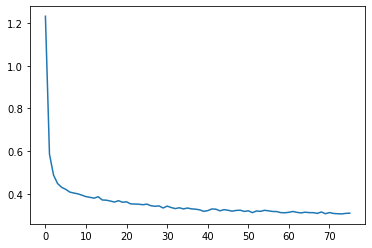

In [117]:
# plot losses
plt.plot(clf.history['loss'])

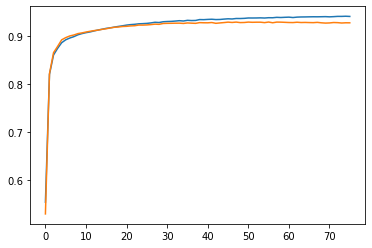

In [118]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

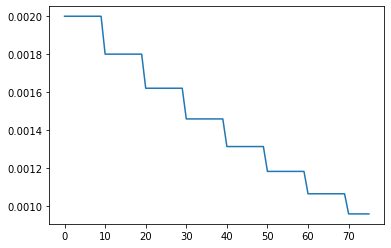

In [119]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [120]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9295409845148064
FINAL TEST SCORE FOR census-income : 0.9270105221199594


In [121]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

<AxesSubplot:>

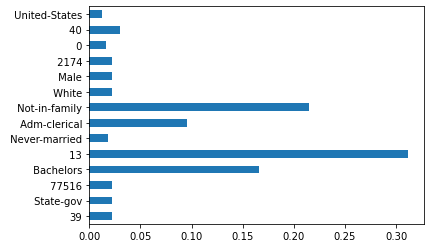

In [122]:
# global
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.plot(kind='barh')

C:\Users\USER\AppData\Local\Temp\ipykernel_182504\58949275.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels = features, rotation=45)


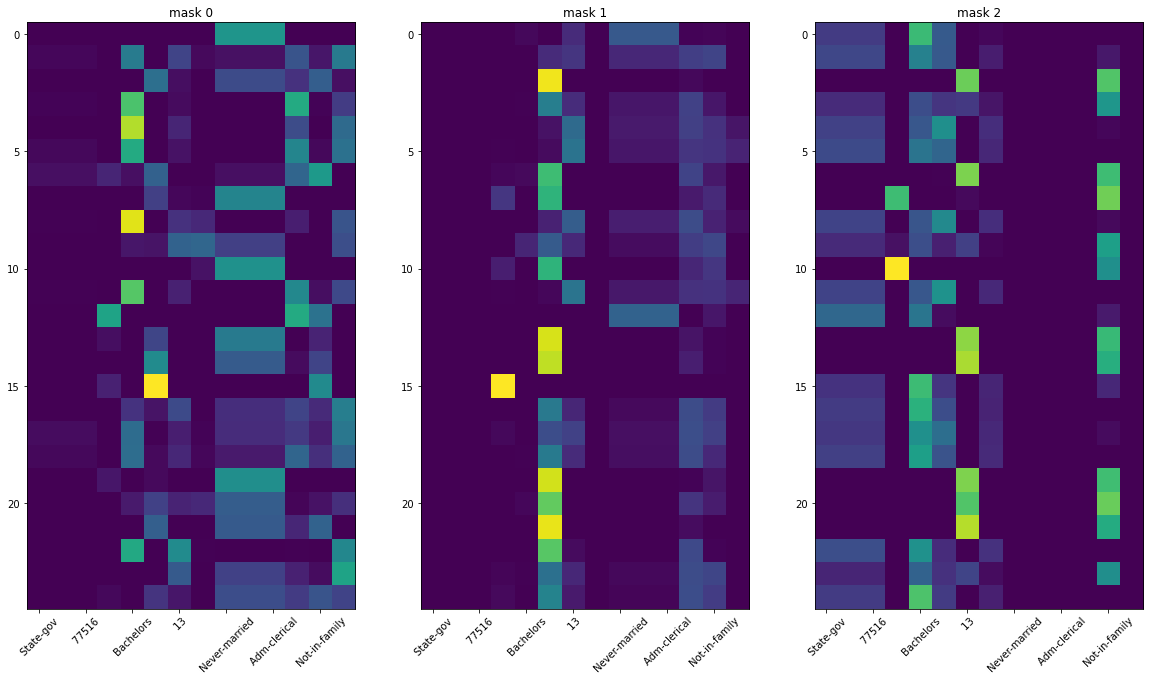

In [123]:
#local

fig, axs = plt.subplots(1, 3, figsize=(20,20))


for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels(labels = features, rotation=45)